## The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.


Our First step is to create instance of spark context which is done by SparkSession and then converted into a spark dataframe . The schema is displayed.
Note:1. If the path is different then change "bank-additional-full.csv" to the path where the csv file is stored
2. Due to the issue of dot operator in spark the column names which had dot have been changed to underscore 

## Import Libraries
#### We open the spark file and also print schema

Note:I saved my .csv file into drive D. And create the enviornment for the spark.Open the jupyter notebook by using pyspark command into the Ananconda promt.   

In [1]:
# Load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from pyspark import SparkContext, SparkConf
from pandas.tools.plotting import scatter_matrix
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import udf


# Load dataset (bank-additional-full.csv)
spark = SparkSession.builder.appName('ml-bank').getOrCreate() #Using a builder design pattern, it instantiates a SparkSession object 
df = spark.read.csv('bank-additional-full.csv', header = True, inferSchema = True, sep=';') # read the .csv file from the drive D.
df.printSchema() #apply schema to the dataframe




root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



We use conventional python libraries (pandas)to understand the data, visualization and find missing values . 
We convert the csv file into a dataframe and use describe them

## Data Understanding 

In [2]:
#To show  First five data entries in the dataset
pd.DataFrame(df.take(6), columns=df.columns).transpose()

0            1            2            3  \
age                      56           57           37           40   
job               housemaid     services     services       admin.   
marital             married      married      married      married   
education          basic.4y  high.school  high.school     basic.6y   
default                  no      unknown           no           no   
housing                  no           no          yes           no   
loan                     no           no           no           no   
contact           telephone    telephone    telephone    telephone   
month                   may          may          may          may   
day_of_week             mon          mon          mon          mon   
duration                261          149          226          151   
campaign                  1            1            1            1   
pdays                   999          999          999          999   
previous                  0            0            0            0   
poutcome        nonexistent  nonexistent  nonexistent  nonexistent   
emp_var_rate            1.1          1.1          1.1          1.1   
cons_price_idx       93.994       93.994       93.994       93.994   
cons_conf_idx         -36.4        -36.4        -36.4        -36.4   
euribor3m             4.857        4.857        4.857        4.857   
nr_employed            5191         5191         5191         5191   
y                        no           no           no           no   

                          4            5  
age                      56           45  
job                services     services  
marital             married      married  
education       high.school     basic.9y  
default                  no      unknown  
housing                  no           no  
loan                    yes           no  
contact           telephone    telephone  
month                   may          may  
day_of_week             mon          mon  
duration                307          198  
campaign                  1            1  
pdays                   999          999  
previous                  0            0  
poutcome        nonexistent  nonexistent  
emp_var_rate            1.1          1.1  
cons_price_idx       93.994       93.994  
cons_conf_idx         -36.4        -36.4  
euribor3m             4.857        4.857  
nr_employed            5191         5191  
y                        no           no

In [3]:
 
print( df.toPandas().describe())

               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp_var_rate  cons_price_idx  cons_conf_idx     euribor3m   nr_employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198    

In [4]:
print (df.toPandas().head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week ...  campaign  pdays  previous     poutcome emp_var_rate  \
0   may         mon ...         1    999         0  nonexistent          1.1   
1   may         mon ...         1    999         0  nonexistent          1.1   
2   may         mon ...         1    999         0  nonexistent          1.1   
3   may         mon ...         1    999         0  nonexistent          1.1   
4   may         mon ...         1    999         0  nonexistent          1.1   

   cons_price_idx  cons_conf_idx  euribor3m  nr_employed   y  

In [5]:
print (df.toPandas().info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int32
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int32
campaign          41188 non-null int32
pdays             41188 non-null int32
previous          41188 non-null int32
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int32(5), object(11)
memory usa

## Missing Values

In [6]:
# To find missing values we use pandas
# These missing values are for only integer datatypes
def count_nulls(df):
    null_counts = []          #make an empty list to hold our results
    for col in df.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        
        #print(ctype)
        if (ctype == str('int')): #skip processing string columns for efficiency (can't have nulls)
           
            nulls = df.where( df[cname].isNull() ).count()
            result = tuple([cname, nulls])  #new tuple, (column name, null count)
            null_counts.append(result)      #put the new tuple in our result list
    return null_counts

null_counts = count_nulls(df)
#null_counts(train)
print (null_counts)

[('age', 0), ('duration', 0), ('campaign', 0), ('pdays', 0), ('previous', 0)]


In [7]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import isnan, when, count, col,sum
ColumnNames = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

#checking for is null
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()
#checking for isnan
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+

## Visualization

Note: For visualization purpose we use pandas dataframe (We convert train dataset into pandas dataframe using toPandas()

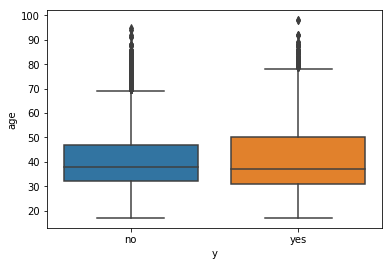

In [8]:
# age
sns.boxplot(x='y', y='age', data=df.toPandas())

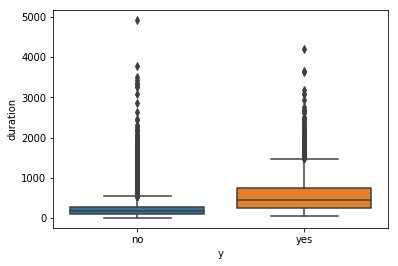

In [9]:
#duration
sns.boxplot(x='y', y='duration', data=df.toPandas())

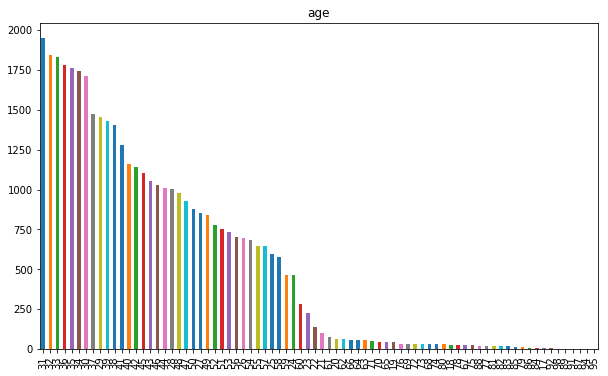

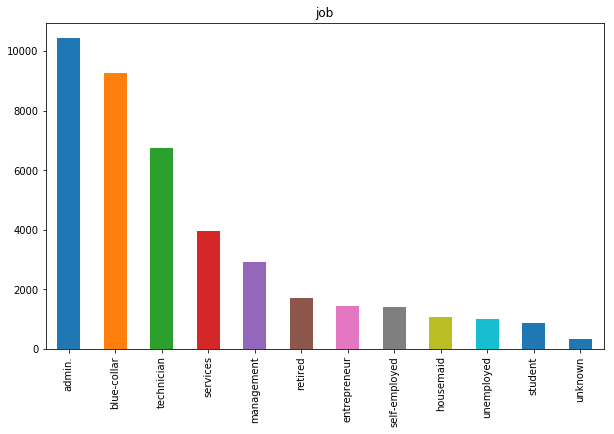

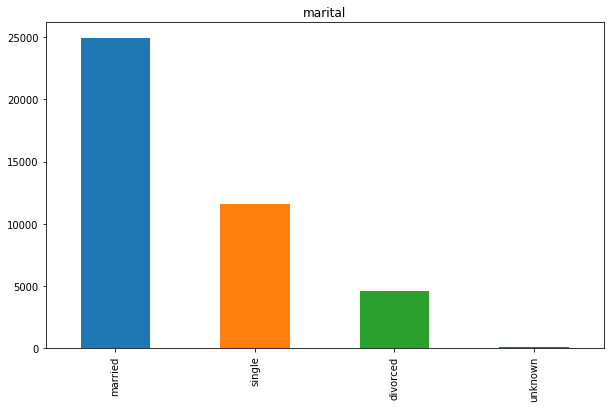

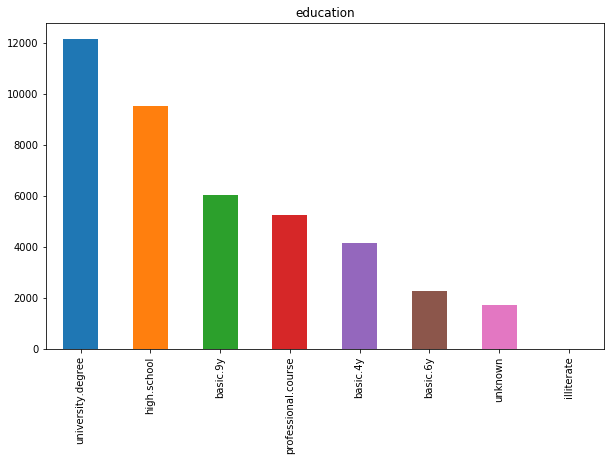

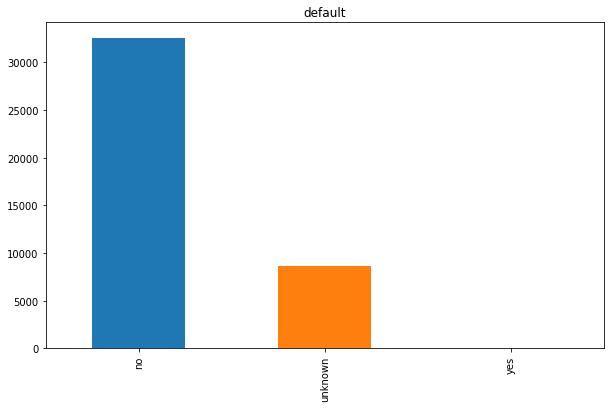

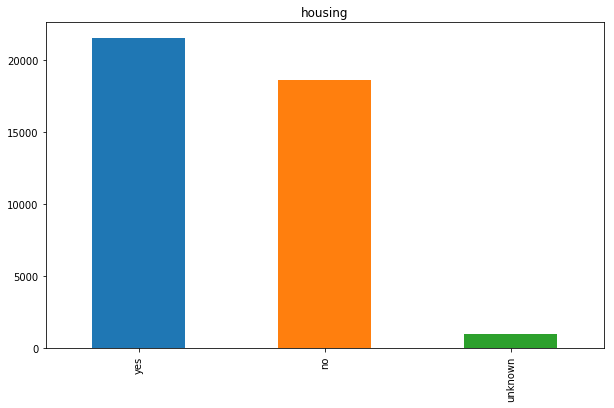

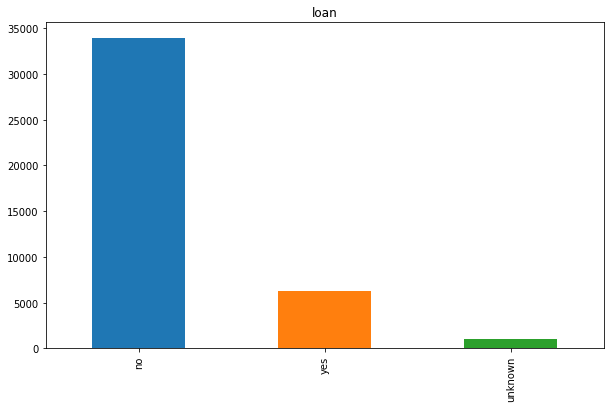

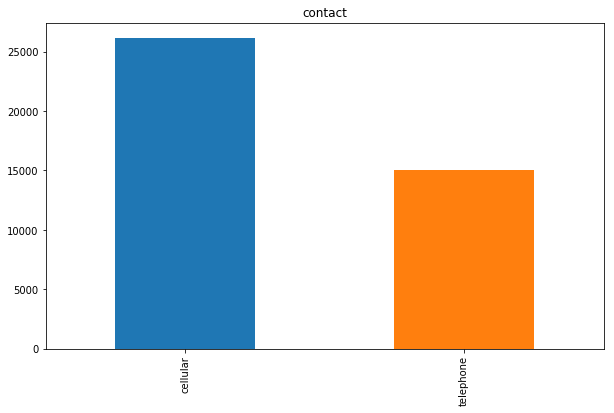

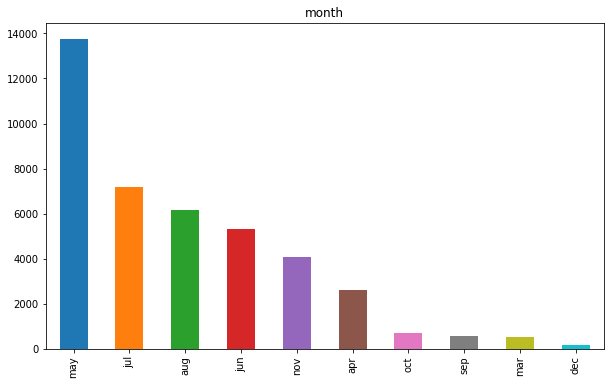

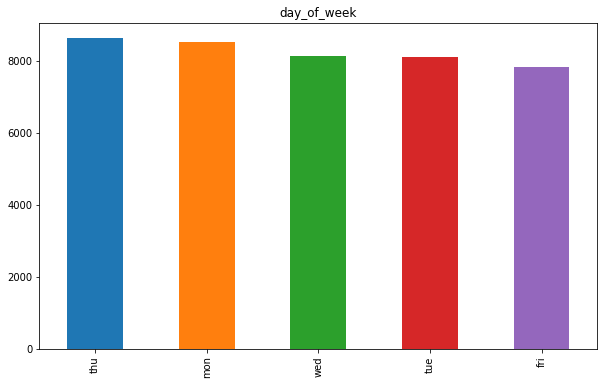

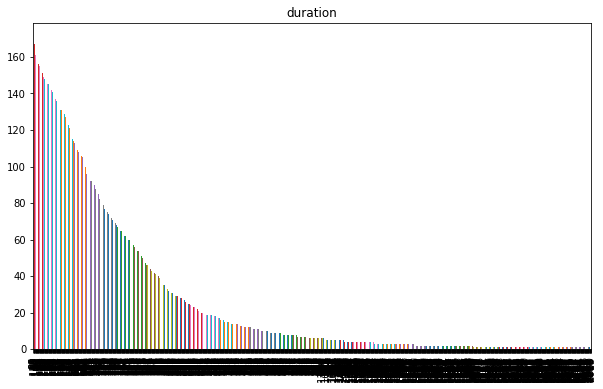

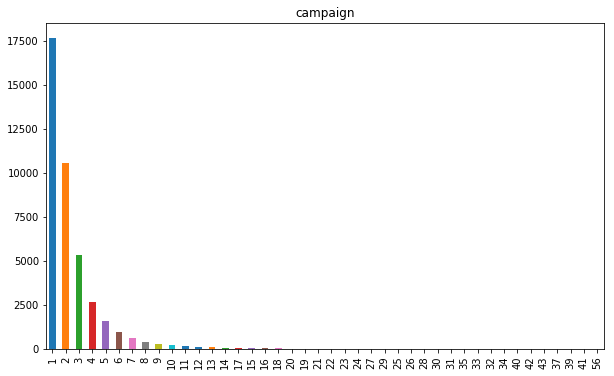

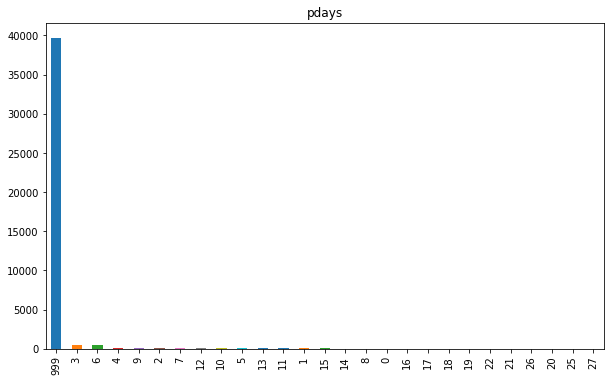

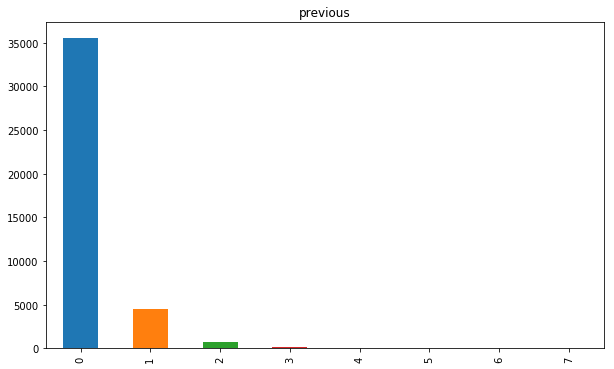

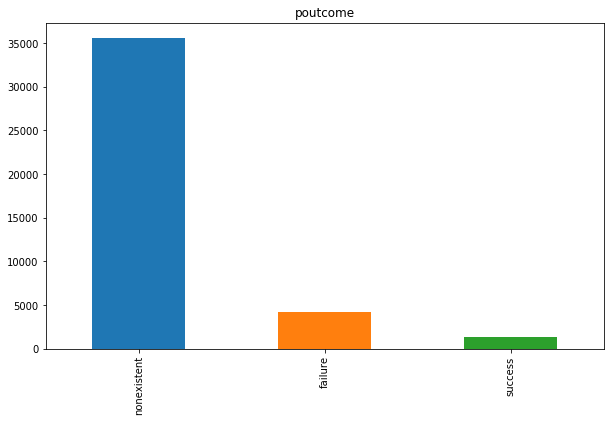

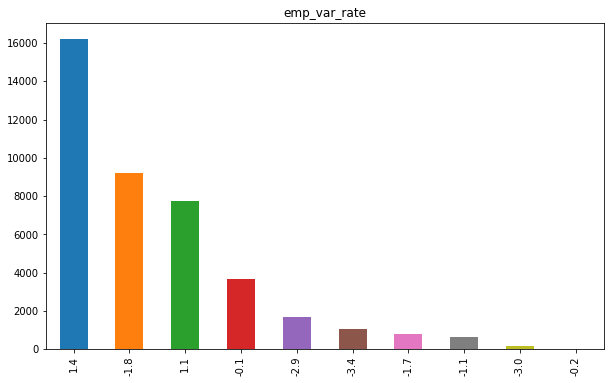

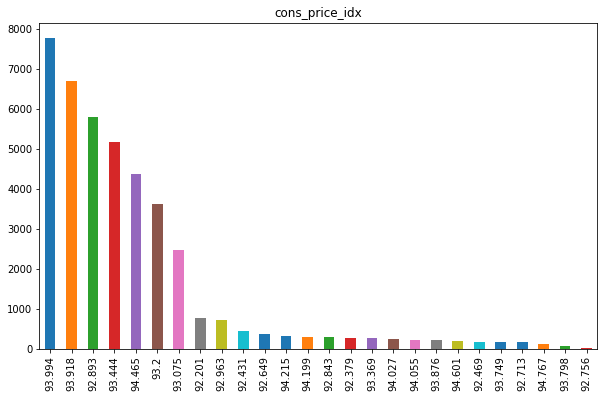

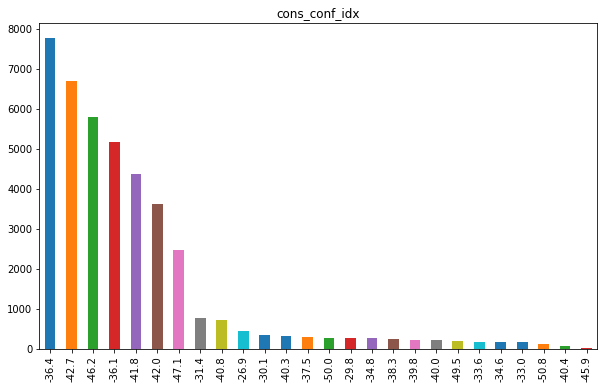

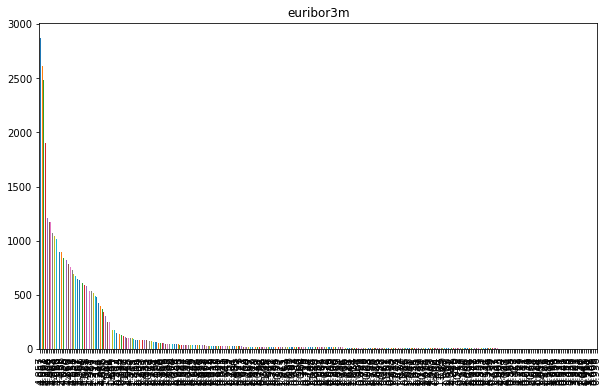

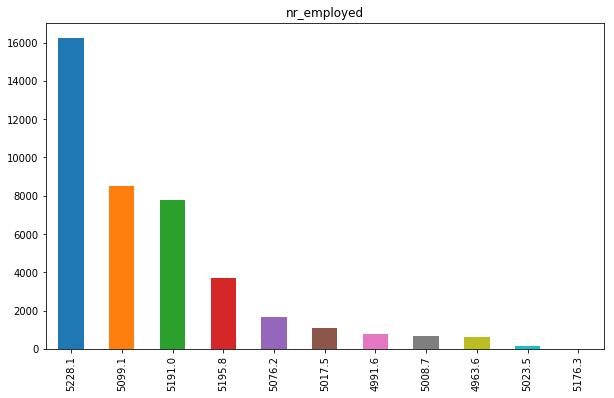

In [10]:
# visualize categorical features
categorical = ColumnNames
for i in categorical:
    df.toPandas()[i].value_counts().plot(kind='bar',figsize = (10, 6),title=i)
    plt.show()

## Splitting into Train and Test

In [11]:
# Divide data into training and testing and display the information
#train, test = df.randomSplit([0.8, 0.2], seed = 2018)
#print("Training Dataset Count value: " + str(train.count()))
#print("Test Dataset Count value: " + str(test.count()))

In [12]:
#We define the features 
Features =[]
for each in df.columns :
    #print(each)
    if each != 'y':
        Features.append(each)
    
X_train = train[Features]
Y_train = train['y']
X_Test = train[Features]
Y_Test = train['y']

NameError: name 'train' is not defined

In [ ]:
# Defining a function for importance

def Importance(Input_Parameter):
    importances=Input_Parameter.feature_importances_
    f=np.argsort(importances)[::-1]
    print ('feature ranking:')
    for i in range(X_train.shape[1]):
         print ("feature no. {}: {} ({})".format(i+1,X_train.columns[f[i]],importances[f[i]]))

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'month', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

In [ ]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
#we have to install ggplot through pip install
#from ggplot import *
from sklearn.preprocessing import label_binarize
from sklearn import *
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

Mean=train['y']
#Mean = train['y'].mean()
print ("the mean of the data is " + str(Mean))
logistic = LogisticRegression()


Logistic_fit = logistic.fit(X_train,Y_train)
Prediction_Model = Logistic_fit.predict(X_train)
score =accuracy_score(Y_train,Prediction_Model)
confusionMatrix = metrics.confusion_matrix(Y_train,Prediction_Model)
importance = Logistic_fit.coef_

print ("The accuracy score is :" + str(score*100) + "\n")

#now finding the classification report
print(classification_report(Y_train, Prediction_Model))

#now we do cross validation just to check if the model does not overfit
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(logistic, X_train, Y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

In [ ]:
#plotting confusion matrix
confusionMatrix = metrics.confusion_matrix(Y_train,Prediction_Model)
norm_conf = []
for i in confusionMatrix:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet,interpolation='nearest')
width, height = confusionMatrix.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(confusionMatrix[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
cb = fig.colorbar(res)
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.show()
